# AccelerateAI: Logistic Regression

## Credit Risk Analysis

Credit Risk analysis is important to understand and score customers better for subsequent decision making by leaders.

The goal of credit risk / scoring models is to predict the creditworthiness of a customer and determine whether they will be able to meet a given financial obligation or default on it. Such models allow a financial institution to minimize the risk of loss by setting decision rules regarding which customers receive loan and credit card approvals and so on for various products and services. 

Logistic regression can be used to predict default events and model the influence of different variables on a consumer’s creditworthines.

We will use a sample dataset to analyze credit risk class - good or bad, based on multiple features.


### Import Libraries and Load Dataset

In [58]:
import numpy as np
import pandas as pd 

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

In [59]:
df = pd.read_csv('./LR_credit_scoring.csv') 

df.head()

,Id,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


Our dataset here includes the following:
- Id
- Age of customer
- Sex
- Job Type: 0/1/2/3 (Unemployed, PartTime Employment, Contractual Employment, FullTime Employment etc.)
- Housing Type: Own/Rent/Free
- Saving Accounts: Little/Moderate/Rich/Quite Rich
- Checking Account: Little/Moderate/Rich
- Credit Amount
- Duration of association with the Bank/Financial Institution (4 months to 72 months)
- Purpose: Credit requested for what purpose (Business / Car / Domestic appliances / Education / Furniture/Equipment / Radio/TV / Repairs / Vacation/others)
- Risk: Good/Bad i.e. 0/1

### EDA, Feature Engg

In [60]:
# Rename some columns by removing unwanted spaces or meaningful names
df.rename(columns={'Saving accounts':'SavingAccounts',
                   'Checking account':'CheckingAccount',
                   'Credit amount':'CreditAmount'} , inplace=True)

# Handle IDness: Remove the Id field which is not relevant
df.drop(columns='Id', inplace=True)

In [61]:
df.head()

,Age,Sex,Job,Housing,SavingAccounts,CheckingAccount,CreditAmount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [62]:
# Check for missing values and handle it accordingly
df.isnull().sum().sum()

577

In [63]:
df_fill_next = df.fillna(method='bfill')

In [64]:
df_fill_next.isnull().sum().sum()

0

In [65]:
df_fill_next.head()

,Age,Sex,Job,Housing,SavingAccounts,CheckingAccount,CreditAmount,Duration,Purpose,Risk
0,67,male,2,own,little,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,little,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [66]:
# Encoding: Handle Categorical features by converting them to dummies, before passing to model
df_encoded = pd.get_dummies(df_fill_next, columns = ['Sex', 'Housing','SavingAccounts','CheckingAccount','Purpose'], drop_first=True)
df_encoded['Risk'].replace(['good','bad'],[0,1],inplace=True)

df_encoded.head()

,Age,Job,CreditAmount,Duration,Risk,Sex_male,Housing_own,Housing_rent,SavingAccounts_moderate,SavingAccounts_quite rich,SavingAccounts_rich,CheckingAccount_moderate,CheckingAccount_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others
0,67,2,1169,6,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,22,2,5951,48,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
2,49,1,2096,12,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,45,2,7882,42,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,53,2,4870,24,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [67]:
df_encoded.columns

Index(['Age', 'Job', 'CreditAmount', 'Duration', 'Risk', 'Sex_male',
       'Housing_own', 'Housing_rent', 'SavingAccounts_moderate',
       'SavingAccounts_quite rich', 'SavingAccounts_rich',
       'CheckingAccount_moderate', 'CheckingAccount_rich', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others'],
      dtype='object')

In [68]:
# Setup X and Y from the dataframe
y = df_encoded['Risk']
X = df_encoded.drop(columns='Risk')
X_const = sm.add_constant(X)

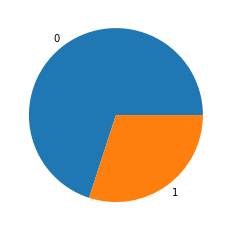

In [69]:
# Distribution of the Risk Feature
# 0 is for Good Risk
# 1 is for Bad Risk
y_freq = y.value_counts()
plt.pie(y_freq, labels=y_freq.index)
plt.show() 

### Modeling using Logit

#### Step 1: Model Diagnostics - start with all features

In [70]:
# Considering the dependent and independent variables
# We will use X_cost (all features with constant term considered for Logit) and y

model_LogReg = sm.Logit(y, X_const).fit()

Optimization terminated successfully.
         Current function value: 0.559760
         Iterations 6


In [71]:
print(model_LogReg.summary2())

                              Results: Logit
Model:                  Logit               Pseudo R-squared:    0.084     
Dependent Variable:     Risk                AIC:                 1159.5198 
Date:                   2022-09-15 15:45    BIC:                 1257.6749 
No. Observations:       1000                Log-Likelihood:      -559.76   
Df Model:               19                  LL-Null:             -610.86   
Df Residuals:           980                 LLR p-value:         2.1281e-13
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         6.0000                                             
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
const                        0.0698   0.5645  0.1236 0.9016 -1.0366  1.1762
Age                         -0.0181   0.007

In [72]:
# LLR p-value for Overall Model Significance
model_LogReg.llr_pvalue

2.1281318530268376e-13

In [73]:
def get_significant_vars(model, alpha=0.05):
    
    #store the variable and p-values in a dataframe
    p_vals = pd.DataFrame(model.pvalues)  
    p_vals['vars'] = p_vals.index
    p_vals.columns = ['pval', 'name']
    
    #return those that are significant at alpha value
    return list(p_vals[p_vals.pval <= alpha]['name'])

In [74]:
significant_vars = get_significant_vars(model_LogReg)

In [75]:
significant_vars

['Age',
 'Duration',
 'Sex_male',
 'Housing_own',
 'SavingAccounts_quite rich',
 'SavingAccounts_rich',
 'CheckingAccount_moderate',
 'CheckingAccount_rich']

LLR p-value < 0.05 indicates Overall Model is Significant.

Some of the individual features are not statistically significant. We can remove features that are not significant and select specific features retrain our model.

#### Step 2: Model Diagnostics - with selected features

In [79]:
# Defining the dependent and independent variables
X_refined = X[significant_vars]

X_const_refined = sm.add_constant(X_refined)

In [80]:
model_LogReg_modified = sm.Logit(y, X_const_refined).fit()

Optimization terminated successfully.
         Current function value: 0.564573
         Iterations 6


In [81]:
print(model_LogReg_modified.summary2())

                             Results: Logit
Model:                  Logit              Pseudo R-squared:   0.076     
Dependent Variable:     Risk               AIC:                1147.1453 
Date:                   2022-09-15 15:47   BIC:                1191.3151 
No. Observations:       1000               Log-Likelihood:     -564.57   
Df Model:               8                  LL-Null:            -610.86   
Df Residuals:           991                LLR p-value:        1.3886e-16
Converged:              1.0000             Scale:              1.0000    
No. Iterations:         6.0000                                           
-------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
const                     -0.2255   0.3051 -0.7393 0.4597 -0.8234  0.3724
Age                       -0.0155   0.0068 -2.2945 0.0218 -0.0288 -0

Since all features seem to be statistically significant, we can go ahead with this as final model.

LLR (Log Likelhood Ratio p-value) indicates Overall Model is significant and we can go ahead with this.

#### Step 3: Final Model

In [82]:
print(model_LogReg_modified.summary2())

                             Results: Logit
Model:                  Logit              Pseudo R-squared:   0.076     
Dependent Variable:     Risk               AIC:                1147.1453 
Date:                   2022-09-15 15:48   BIC:                1191.3151 
No. Observations:       1000               Log-Likelihood:     -564.57   
Df Model:               8                  LL-Null:            -610.86   
Df Residuals:           991                LLR p-value:        1.3886e-16
Converged:              1.0000             Scale:              1.0000    
No. Iterations:         6.0000                                           
-------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
const                     -0.2255   0.3051 -0.7393 0.4597 -0.8234  0.3724
Age                       -0.0155   0.0068 -2.2945 0.0218 -0.0288 -0

In [83]:
# standard error
model_LogReg_modified.bse

const                        0.305059
Age                          0.006777
Duration                     0.005897
Sex_male                     0.158713
Housing_own                  0.155597
SavingAccounts_quite rich    0.299571
SavingAccounts_rich          0.379364
CheckingAccount_moderate     0.152682
CheckingAccount_rich         0.274796
dtype: float64

#### Answer BQs

In [84]:
# Defining the dependent and independent variables
X = df_encoded[['Age', 'Duration','Sex_male', 'Housing_own','CheckingAccount_moderate', 'CheckingAccount_rich']]

# Add constant term
X_const = sm.add_constant(X)

In [85]:
model_LR_for_BQ = sm.Logit(y, X_const).fit()

Optimization terminated successfully.
         Current function value: 0.569370
         Iterations 6


In [86]:
print(model_LR_for_BQ.summary2())

                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.068     
Dependent Variable:    Risk               AIC:                1152.7400 
Date:                  2022-09-15 15:49   BIC:                1187.0942 
No. Observations:      1000               Log-Likelihood:     -569.37   
Df Model:              6                  LL-Null:            -610.86   
Df Residuals:          993                LLR p-value:        8.6122e-16
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        6.0000                                           
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
const                    -0.3033   0.3024 -1.0027 0.3160 -0.8960  0.2895
Age                      -0.0162   0.0068 -2.3935 0.0167 -0.0294 -0.0029
Duratio

**1) Find the probability that a customer will have bad credit risk profile considering male, owns housing and rich status as per checking accounts?**

log (p / 1-p) = -0.3033 - 0.3285 * 1 - 0.5210 * 1 - 0.8113 * 1
              = -1.9638
              
=> p / 1-p = exp (-1.9638) = 0.1403

=> 1.1403p = 0.1403

=> p = 12.3%

**Therefore, we can infer - Male Customer who owns housing and is having "rich" status as per checking accounts has a probability of default or credit risk of 12.3%**

Similarly we can provide interpretation for any situations.

The computations are captured below which are used above.

In [87]:
-0.303 - 0.3285 * 1 - 0.5210 * 1 - 0.8113 * 1

-1.9638

In [88]:
np.exp(-1.9638)

0.14032417463236974

In [89]:
0.1403/1.1403

0.12303779707094624

**2) Find the probability that a customer will have bad credit risk profile considering female, owns housing and rich status as per checking accounts?**

log (p / 1-p) = -0.303 - 0.3285 * 0 - 0.5210 * 1 - 0.8113 * 1
              = -1.6353
              
=> p = 16.31%

In [90]:
-0.303 - 0.3285 * 0 - 0.5210 * 1 - 0.8113 * 1

-1.6353

In [91]:
np.exp(-1.6353)

0.19489389435977222

In [92]:
.1949/1.1949

0.1631098836722738

That's all!!

We can use sklearn family's LogisticRegression and predict risk for new users.